# SOEN471-PROJECT - Suicide and Depression Sentiment Analysis - Team 13

# Team Members:
- Mohammad Ali Zahir - 40077619
- Samantha Guillemette - 26609198
- Marita Brichan - 40138194	
- Souvik Polol Alam	- 40044092	

## Librairies

### Run next cell to install all the required libraries

In [54]:
# !pip install dask-ml
# !pip install seaborn
# !pip install neattext
# !pip install tqdm
# !pip install nltk
# !pip install scikit-learn
# !pip install tabulate 

### Librairies Used

In [55]:
import dask.dataframe as dd
import dask.array as da
import dask_ml.preprocessing as dmp
import dask_ml.model_selection as dms
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import neattext.functions as nfx
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate

## Load Data

In [56]:
dask = dd.read_csv("./data/Suicide_Detection.csv")
dask = dask.drop('Unnamed: 0', axis = 1)

dask.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Previewing Data

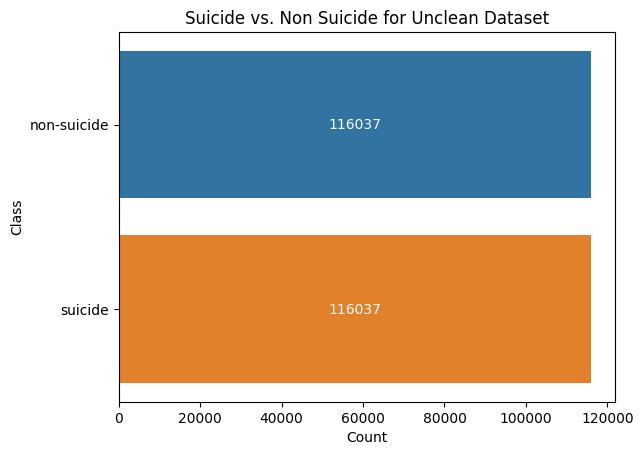

In [57]:
class_counts = dask['class'].value_counts().compute()

# Create a bar plot of the value counts using Seaborn
ax = sns.barplot(x=class_counts.values, y=class_counts.index)

for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2,
            str(class_counts.values[i]), fontsize=10, color='white', ha='center', va='center')


# Add a title, x-label, and y-label to the plot
plt.title('Suicide vs. Non Suicide for Unclean Dataset')
plt.xlabel('Count')
plt.ylabel('Class')

# Show the plot
plt.show()

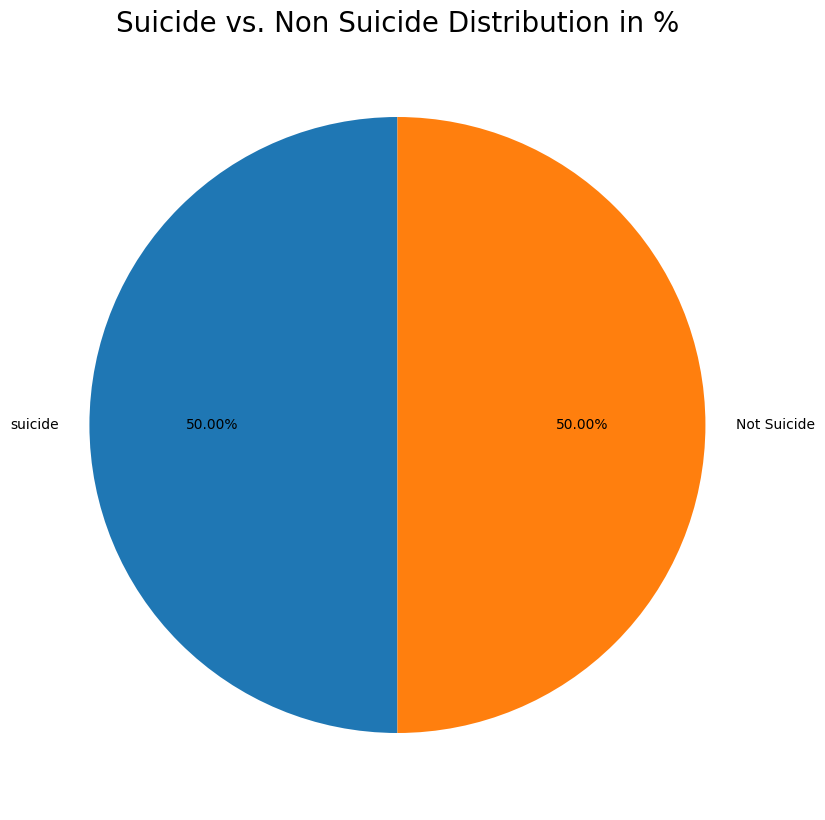

In [58]:
plt.figure(figsize=(10,10))
plt.pie(class_counts.values, startangle=90, autopct='%0.2f%%', labels=['suicide','Not Suicide'])
plt.title('Suicide vs. Non Suicide Distribution in %',fontdict={'size':20})
plt.show()

# Preprocessing Data

In [59]:
# Create a function which preprocess the text by using the nltk, neattext and WordNetLemmatizer and the tqdm librairies
def preprocess_text(text):
    processed_text=[]
    lemmatizer = WordNetLemmatizer()
    for sequence in tqdm(text):
        sequence=sequence.lower()
        sequence=nfx.remove_special_characters(sequence)
        sequence=nfx.remove_stopwords(sequence)
        sequence = nfx.remove_emojis(sequence)
        words = nltk.word_tokenize(sequence)
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        sequence = ' '.join(lemmatized_words)
        processed_text.append(sequence)
    return processed_text


## Splitting Training and Test Data

In [60]:
train_data,test_data=dms.train_test_split(dask,test_size=0.2,random_state=10, shuffle=True)

#### Visualize Split Data

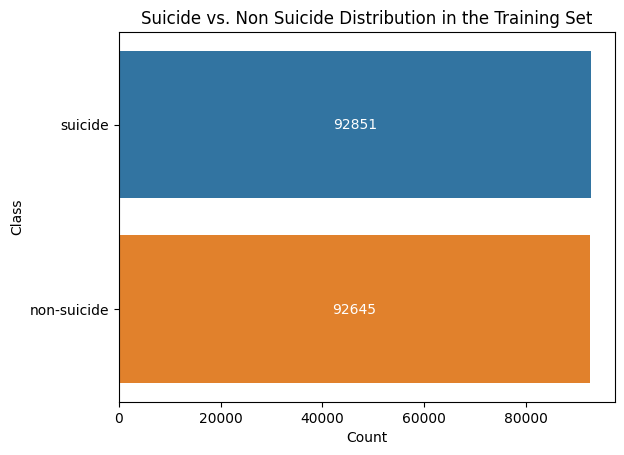

In [61]:
train_counts = train_data['class'].value_counts().compute()

ax = sns.barplot(x=train_counts.values, y=train_counts.index)

# Add the count value inside each bar
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2,
            str(train_counts.values[i]), fontsize=10, color='white', ha='center', va='center')

# Add a title, x-label, and y-label to the plot
plt.title('Suicide vs. Non Suicide Distribution in the Training Set')
plt.xlabel('Count')
plt.ylabel('Class')

# Show the plot
plt.show()

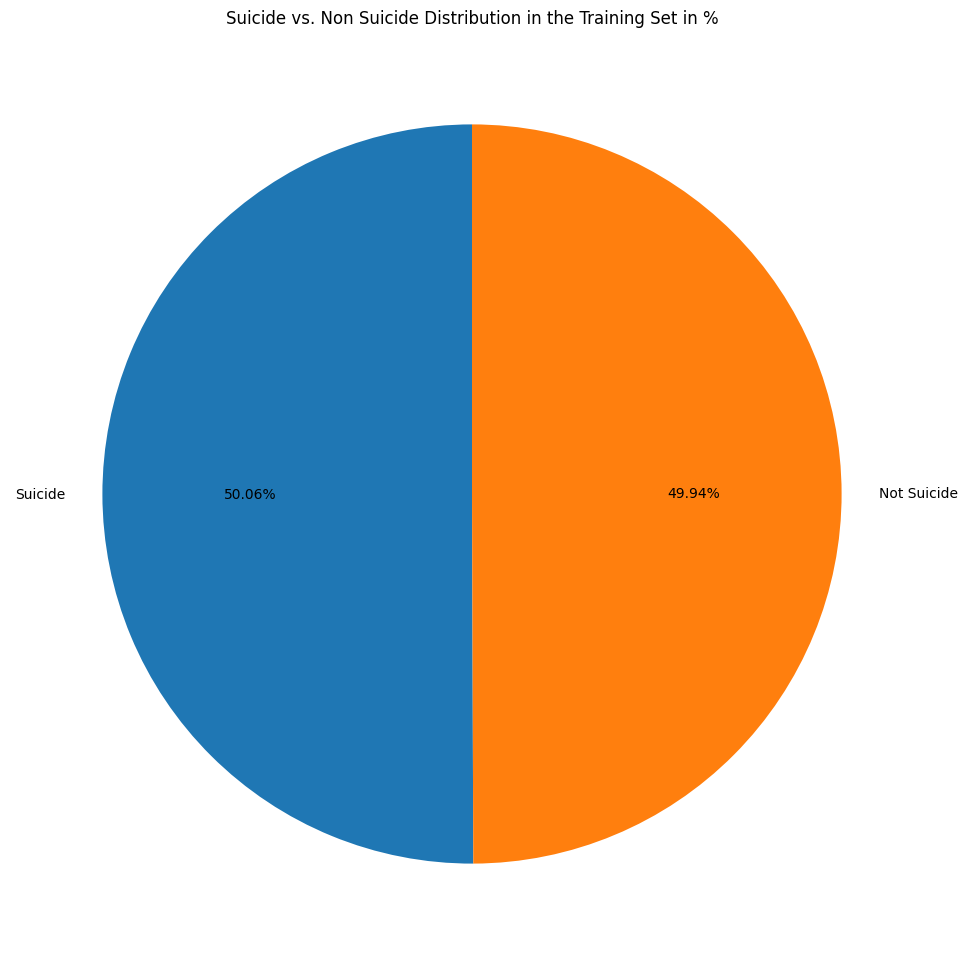

In [62]:
plt.figure(figsize=(12,12))
plt.pie(train_counts.values, startangle=90, autopct='%0.2f%%', labels=['Suicide','Not Suicide'])
plt.title('Suicide vs. Non Suicide Distribution in the Training Set in %')
plt.show()

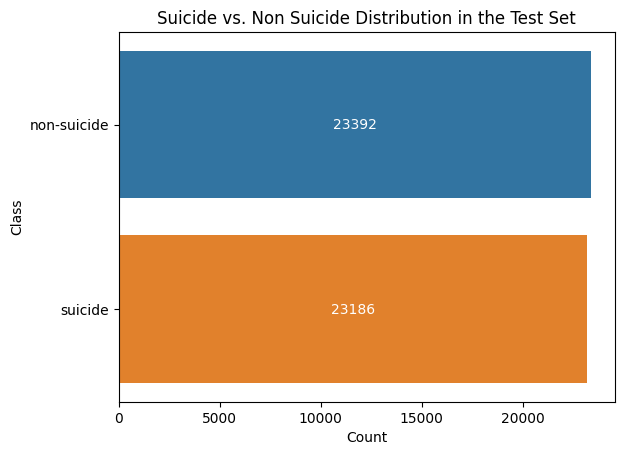

In [63]:
test_counts = test_data['class'].value_counts().compute()

ax = sns.barplot(x=test_counts.values, y=test_counts.index)

# Add the count value inside each bar
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2,
            str(test_counts.values[i]), fontsize=10, color='white', ha='center', va='center')

# Add a title, x-label, and y-label to the plot
plt.title('Suicide vs. Non Suicide Distribution in the Test Set')
plt.xlabel('Count')
plt.ylabel('Class')

# Show the plot
plt.show()

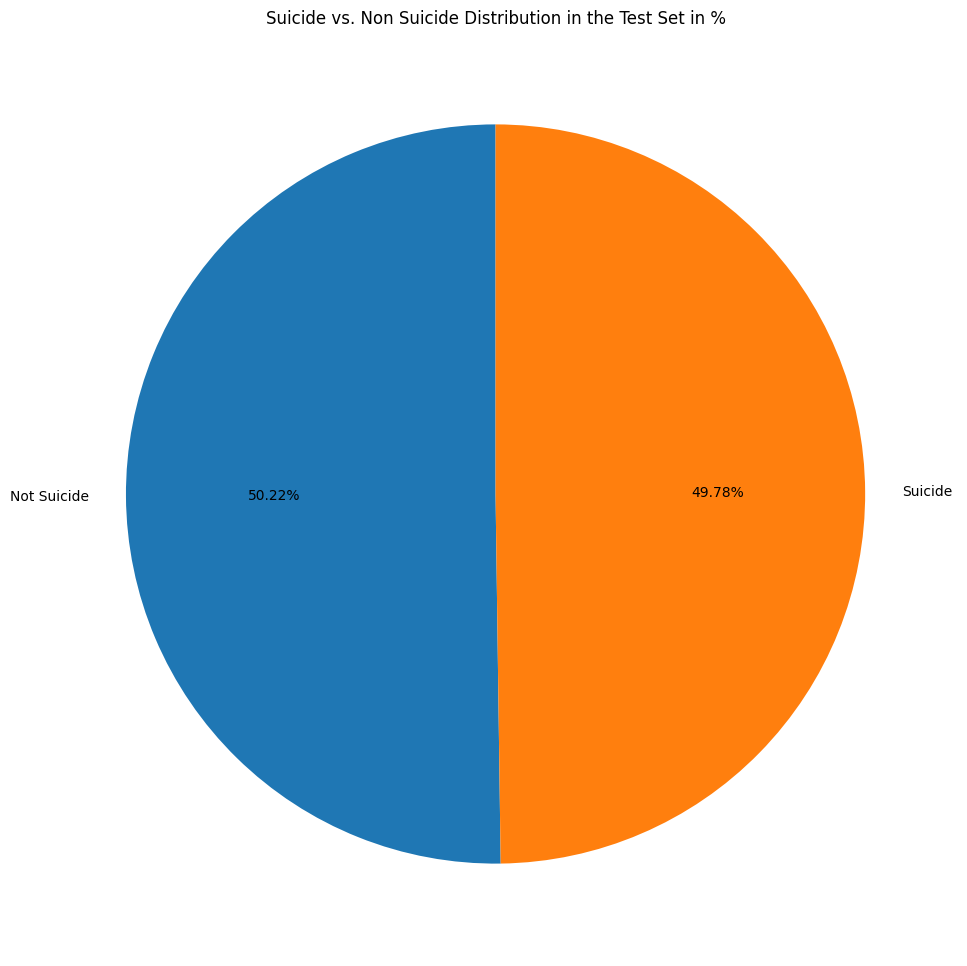

In [64]:
plt.figure(figsize=(12,12))
plt.pie(test_counts.values, startangle=90, autopct='%0.2f%%', labels=['Not Suicide','Suicide'])
plt.title('Suicide vs. Non Suicide Distribution in the Test Set in %')
plt.show()

### Preprocessing Split Data

In [65]:
cleaned_train_text=preprocess_text(train_data.text.compute())
cleaned_test_text=preprocess_text(test_data.text.compute())

100%|██████████| 46578/46578 [00:11<00:00, 4097.00it/s]


### Visualize Cleaned Split Data

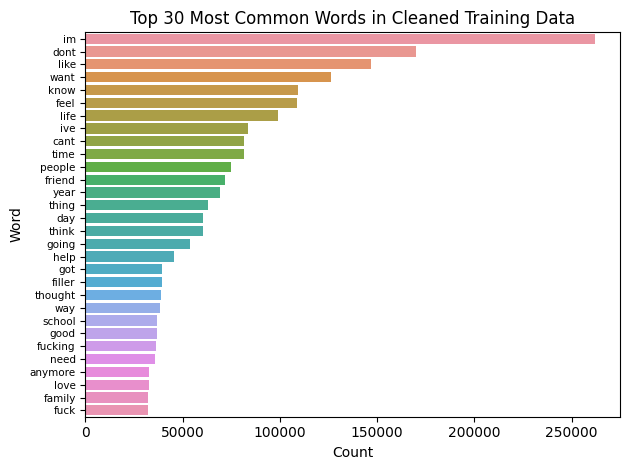

In [66]:
# Join all cleaned texts into one long string
all_train_text = ' '.join(cleaned_train_text)

# Tokenize the text using NLTK
words = nltk.tokenize.word_tokenize(all_train_text)

# Lemmatize the words using NLTK's WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
words = [lemmatizer.lemmatize(word) for word in words]

# Compute the frequency of each word using NLTK's FreqDist function
word_freq = nltk.FreqDist(words)

# Extract the 50 most common words
top_words = word_freq.most_common(30)

# Create a bar plot of the top 50 words using Seaborn
sns.barplot(x=[word[1] for word in top_words], y=[word[0] for word in top_words])
plt.title('Top 30 Most Common Words in Cleaned Training Data')
plt.xlabel('Count')
plt.ylabel('Word')
plt.yticks(fontsize=7.5)
plt.gca().tick_params(axis='y', which='major', labelsize=7.5)
plt.tight_layout()
plt.show()

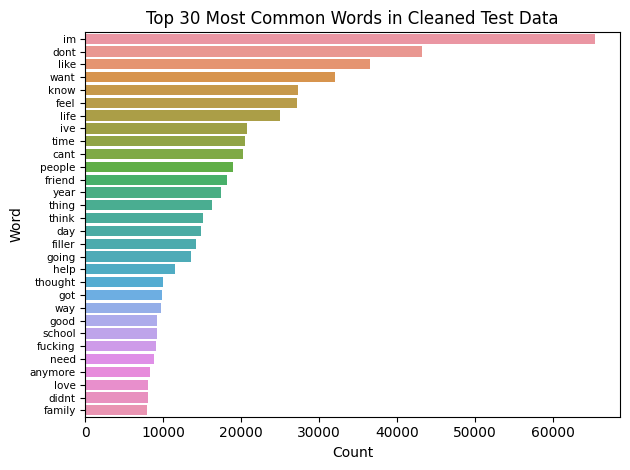

In [67]:
# Join all cleaned texts into one long string
all_test_text = ' '.join(cleaned_test_text)

# Tokenize the text using NLTK
words = nltk.tokenize.word_tokenize(all_test_text)

# Lemmatize the words using NLTK's WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
words = [lemmatizer.lemmatize(word) for word in words]

# Compute the frequency of each word using NLTK's FreqDist function
word_freq = nltk.FreqDist(words)

# Extract the 50 most common words
top_words = word_freq.most_common(30)

# Create a bar plot of the top 50 words using Seaborn
sns.barplot(x=[word[1] for word in top_words], y=[word[0] for word in top_words])
plt.title('Top 30 Most Common Words in Cleaned Test Data')
plt.xlabel('Count')
plt.ylabel('Word')
plt.yticks(fontsize=7.5)
plt.gca().tick_params(axis='y', which='major', labelsize=7.5)
plt.tight_layout()
plt.show()

## Vectorize Data

In [68]:
# Create a TF-IDF vectorizer object
vectorizer = TfidfVectorizer()

# Vectorize the cleaned training and test data
X_train = vectorizer.fit_transform(cleaned_train_text)
X_test = vectorizer.transform(cleaned_test_text)

# Get the target values for the training and test data
y_train = train_data['class'].compute().values
y_test = test_data['class'].compute().values

## Applying Models

### Multinomial Naive Bayes Model Training and Prediction

In [69]:
# Train a Multinomial Naive Bayes classifier on the transformed data
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_nb = clf.predict(X_test)

classes = clf.classes_

### Random Forest Model Training and Prediction

In [70]:
# Create a Random Forest Classifier object
clf_rf = RandomForestClassifier(n_estimators=10, random_state=10)

# Fit the classifier on the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = clf_rf.predict(X_test)

### Random Forest Model Training and Prediction with estimators 50

In [71]:
# Create a Random Forest Classifier object
clf_rf2 = RandomForestClassifier(n_estimators=50, random_state=10)

# Fit the classifier on the training data
clf_rf2.fit(X_train, y_train)

# Predict on the test data
y_pred_rf2 = clf_rf2.predict(X_test)

## Evaluate Models

### Multinomial Naive Bayes Model Evaluation

In [72]:
# # Print the classification report
nb_class_report = classification_report(y_test, y_pred_nb, output_dict=True)

# Convert the dictionary to a pandas dataframe
df_nb = pd.DataFrame(nb_class_report).transpose()

# Format the values as percentages
df_nb.loc[:, 'precision':'f1-score'] = df_nb.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table = tabulate(df_nb.drop('accuracy'), headers='keys',tablefmt="grid",
            stralign="right", numalign="right")
print(f"The Classification report for the Multinomial Naive Bayes Model\n {report_table}")

# Print the accuracy score separately
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"\nAccuracy Score of the Multinomial Naive Bayes Model: {accuracy:.2%}")

The Classification report for the Multinomial Naive Bayes Model
 +--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
|  non-suicide |      97.65% |   76.33% |     85.69% |     23392 |
+--------------+-------------+----------+------------+-----------+
|      suicide |      80.43% |   98.15% |     88.41% |     23186 |
+--------------+-------------+----------+------------+-----------+
|    macro avg |      89.04% |   87.24% |     87.05% |     46578 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      89.08% |   87.19% |     87.04% |     46578 |
+--------------+-------------+----------+------------+-----------+

Accuracy Score of the Multinomial Naive Bayes Model: 87.19%


### Naive Bayes Classification Report Metrics

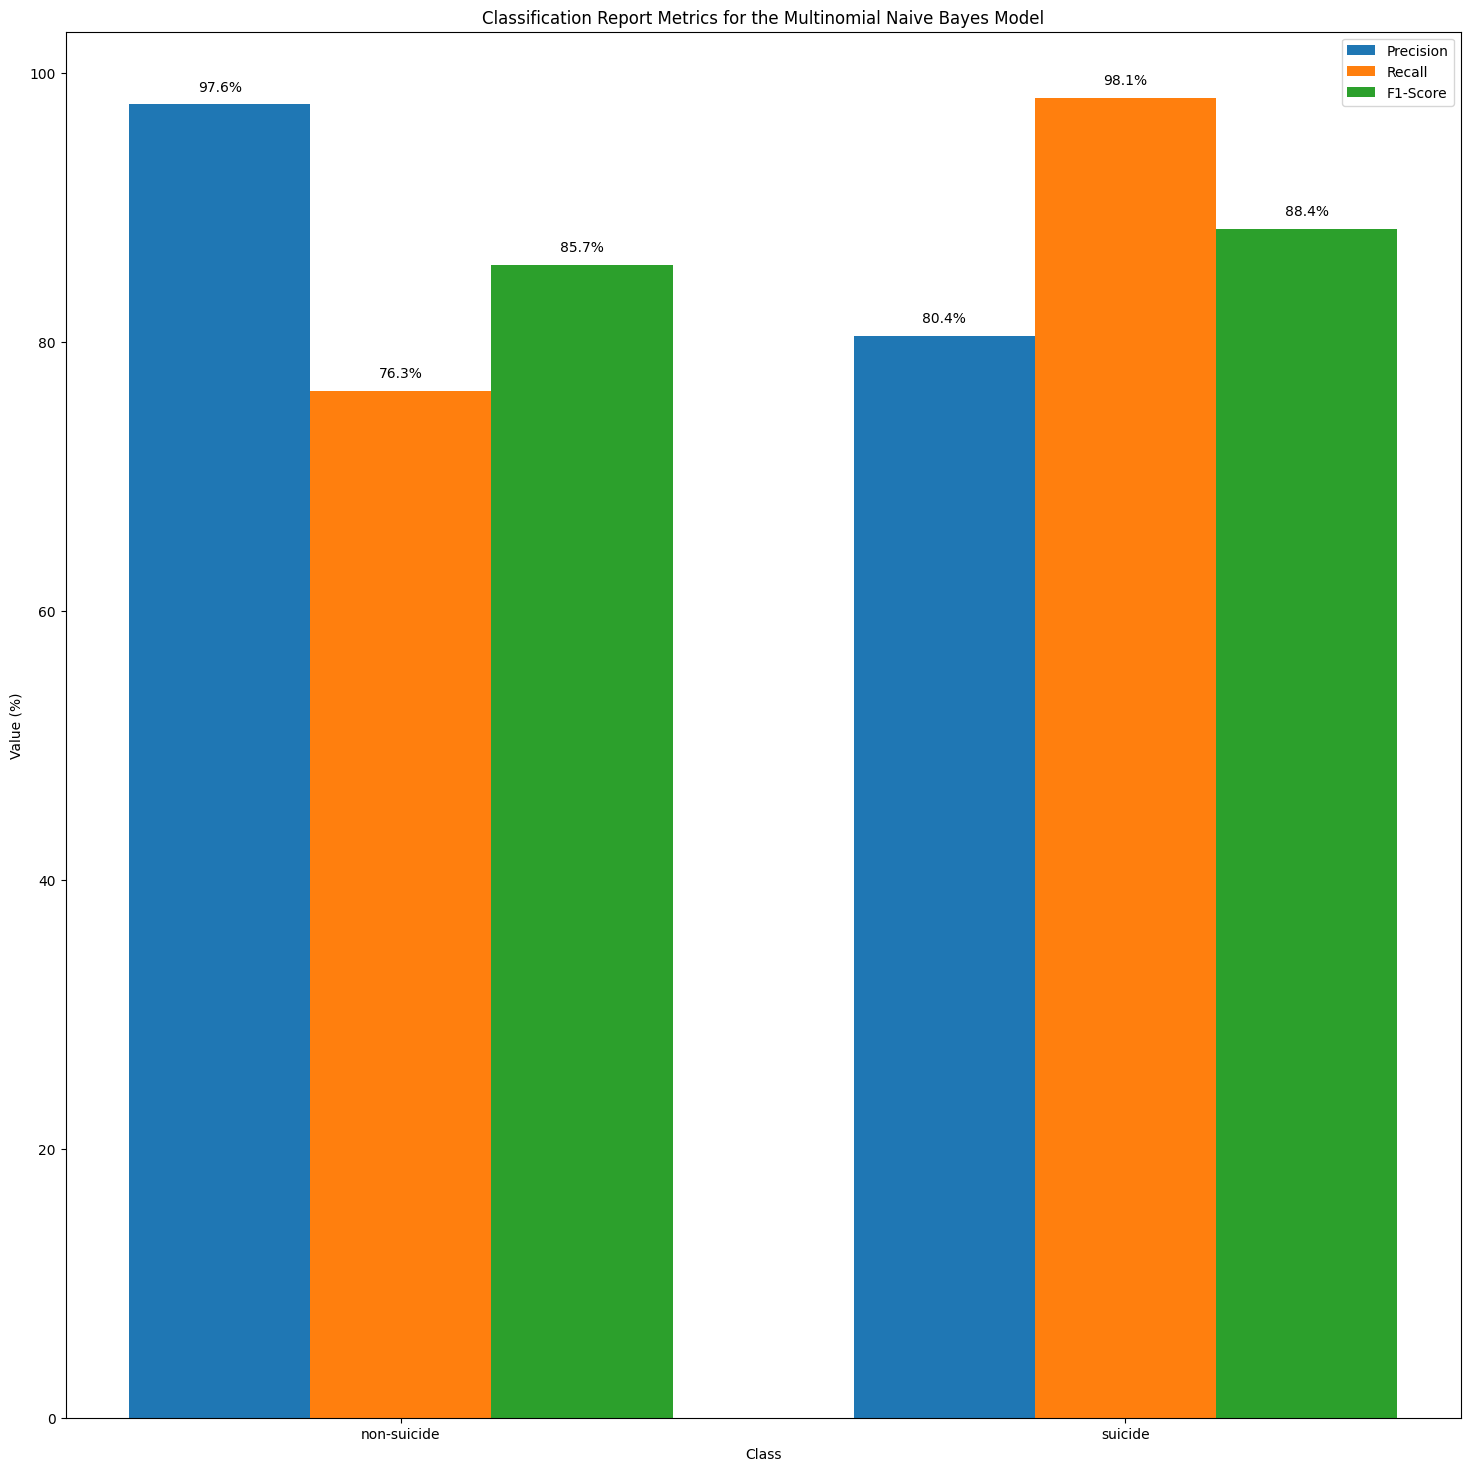

In [73]:
# Get the unique labels in the data
labels = np.unique(y_test)


# Extract the precision, recall, and f1-score values for each class
precision = [nb_class_report[label]['precision'] for label in labels]
recall = [nb_class_report[label]['recall'] for label in labels]
f1_score = [nb_class_report[label]['f1-score'] for label in labels]

# Convert the values to percentages
precision_pct = [p * 100 for p in precision]
recall_pct = [r * 100 for r in recall]
f1_score_pct = [f * 100 for f in f1_score]

# Create a bar plot for each metric
x_pos = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(18,18))
ax.bar(x_pos - width, precision_pct, width, label='Precision')
ax.bar(x_pos, recall_pct, width, label='Recall')
ax.bar(x_pos + width, f1_score_pct, width, label='F1-Score')

# Set the axis labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Value (%)')
ax.set_title('Classification Report Metrics for the Multinomial Naive Bayes Model')

# Set the tick labels and legend
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.legend()

# Add the percentage values as text above each bar
for i in range(len(labels)):
    ax.text(x_pos[i] - width, precision_pct[i] + 1, f'{precision_pct[i]:.1f}%', ha='center')
    ax.text(x_pos[i], recall_pct[i] + 1, f'{recall_pct[i]:.1f}%', ha='center')
    ax.text(x_pos[i] + width, f1_score_pct[i] + 1, f'{f1_score_pct[i]:.1f}%', ha='center')

# Show the plot
plt.show()

### Naive Bayes Confusion Matrix

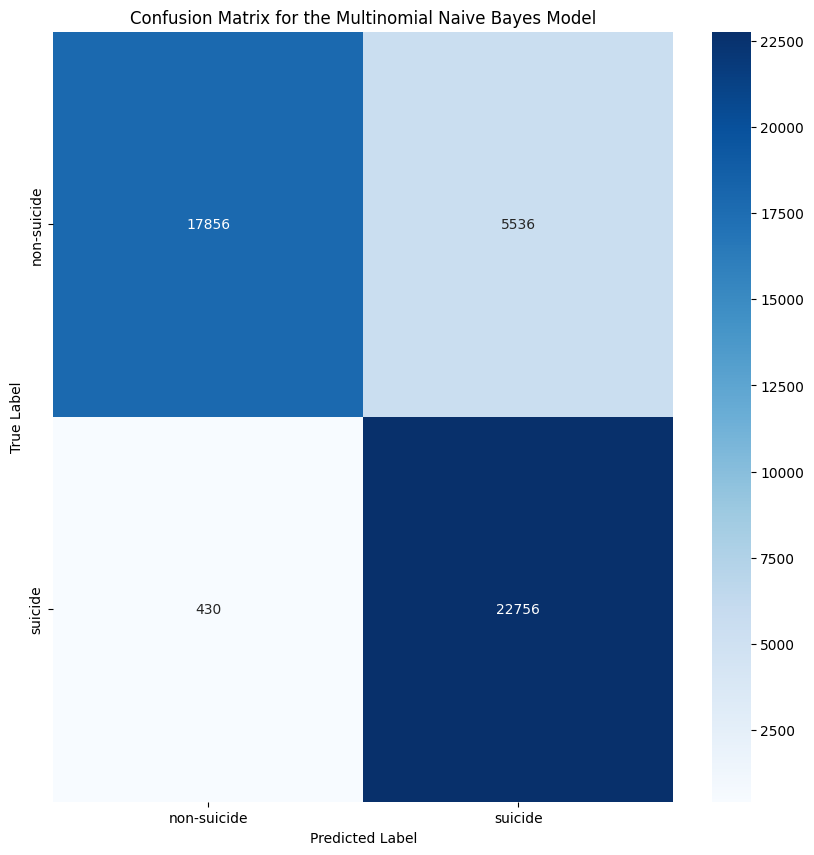

In [74]:
# Create the confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Create the heatmap using seaborn
plt.subplots(figsize=(10,10))
sns.heatmap(cm_nb, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

# Set the axis labels
plt.title('Confusion Matrix for the Multinomial Naive Bayes Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()

### Random Forest Model Evaluation with estimators 10

In [75]:
# # Print the classification report
rfc_class_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Convert the dictionary to a pandas dataframe
df_rf = pd.DataFrame(rfc_class_report).transpose()

# Format the values as percentages
df_rf.loc[:, 'precision':'f1-score'] = df_rf.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table = tabulate(df_rf.drop('accuracy'), headers='keys',tablefmt="grid",
            stralign="right", numalign="right")
print(f"The Classification report for the Random Forest Model\n {report_table}")

# Print the accuracy score separately
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy Score of the Random Forest Model: {accuracy:.2%}")


The Classification report for the Random Forest Model
 +--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
|  non-suicide |      86.08% |   90.08% |     88.03% |     23392 |
+--------------+-------------+----------+------------+-----------+
|      suicide |      89.50% |   85.30% |     87.35% |     23186 |
+--------------+-------------+----------+------------+-----------+
|    macro avg |      87.79% |   87.69% |     87.69% |     46578 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      87.78% |   87.70% |     87.69% |     46578 |
+--------------+-------------+----------+------------+-----------+

Accuracy Score of the Random Forest Model: 87.70%


### Random Forest Model Evaluation with Estimators 50

In [76]:
# # Print the classification report
rfc_class_report2 = classification_report(y_test, y_pred_rf2, output_dict=True)

# Convert the dictionary to a pandas dataframe
df_rf2 = pd.DataFrame(rfc_class_report2).transpose()

# Format the values as percentages
df_rf2.loc[:, 'precision':'f1-score'] = df_rf2.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table2 = tabulate(df_rf2.drop('accuracy'), headers='keys',tablefmt="grid",
            stralign="right", numalign="right")
print(f"The Classification report for the Random Forest Model\n {report_table2}")

# Print the accuracy score separately
accuracy = accuracy_score(y_test, y_pred_rf2)
print(f"\nAccuracy Score of the Random Forest Model: {accuracy:.2%}")

The Classification report for the Random Forest Model
 +--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
|  non-suicide |      90.61% |   90.04% |     90.32% |     23392 |
+--------------+-------------+----------+------------+-----------+
|      suicide |      90.01% |   90.58% |     90.30% |     23186 |
+--------------+-------------+----------+------------+-----------+
|    macro avg |      90.31% |   90.31% |     90.31% |     46578 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |      90.31% |   90.31% |     90.31% |     46578 |
+--------------+-------------+----------+------------+-----------+

Accuracy Score of the Random Forest Model: 90.31%


### Random Forest Classification Report Metrics Estimators 10

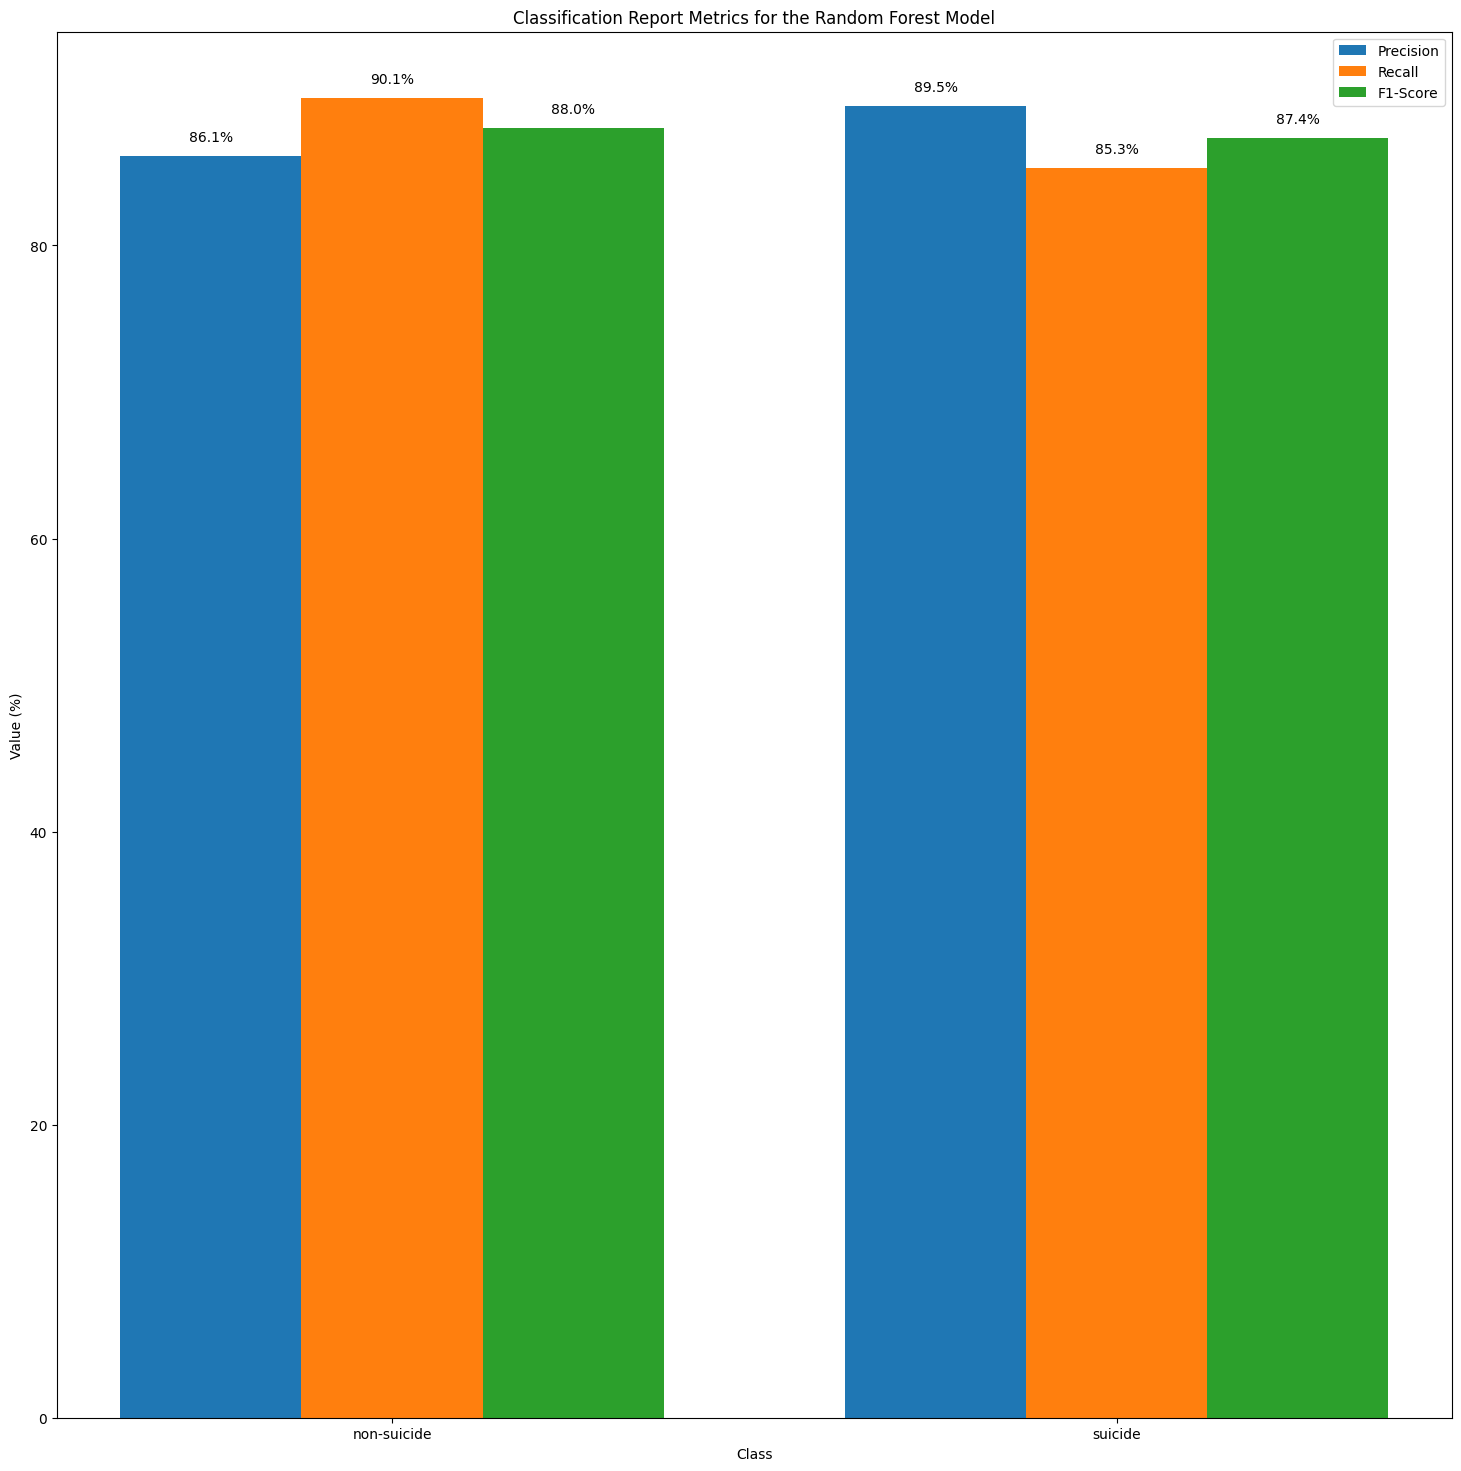

In [77]:
# Get the unique labels in the data
labels = np.unique(y_test)


# Extract the precision, recall, and f1-score values for each class
precision = [rfc_class_report[label]['precision'] for label in labels]
recall = [rfc_class_report[label]['recall'] for label in labels]
f1_score = [rfc_class_report[label]['f1-score'] for label in labels]

# Convert the values to percentages
precision_pct = [p * 100 for p in precision]
recall_pct = [r * 100 for r in recall]
f1_score_pct = [f * 100 for f in f1_score]

# Create a bar plot for each metric
x_pos = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(18,18))
ax.bar(x_pos - width, precision_pct, width, label='Precision')
ax.bar(x_pos, recall_pct, width, label='Recall')
ax.bar(x_pos + width, f1_score_pct, width, label='F1-Score')

# Set the axis labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Value (%)')
ax.set_title('Classification Report Metrics for the Random Forest Model')

# Set the tick labels and legend
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.legend()

# Add the percentage values as text above each bar
for i in range(len(labels)):
    ax.text(x_pos[i] - width, precision_pct[i] + 1, f'{precision_pct[i]:.1f}%', ha='center')
    ax.text(x_pos[i], recall_pct[i] + 1, f'{recall_pct[i]:.1f}%', ha='center')
    ax.text(x_pos[i] + width, f1_score_pct[i] + 1, f'{f1_score_pct[i]:.1f}%', ha='center')

# Show the plot
plt.show()

### Random Forest Classification Report Metrics Estimators 50

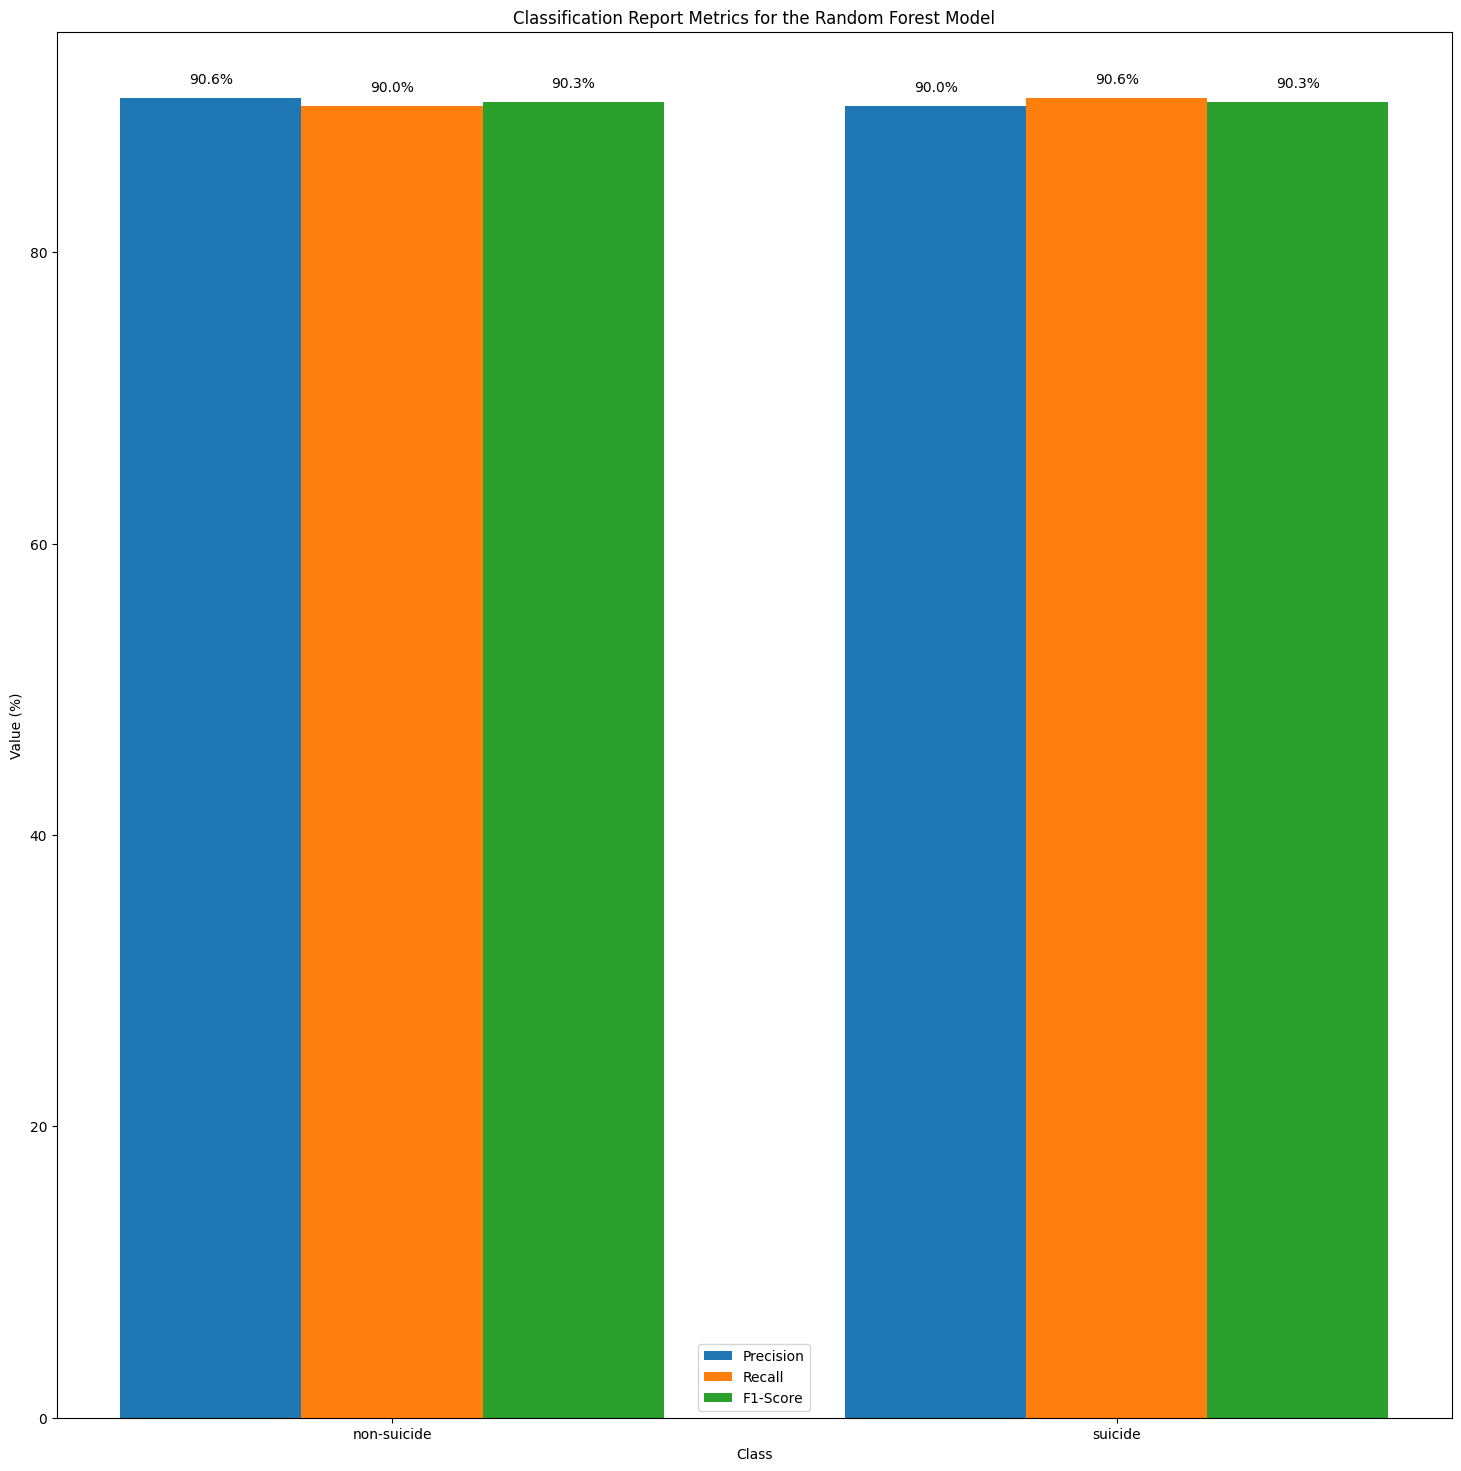

In [78]:
# Get the unique labels in the data
labels = np.unique(y_test)


# Extract the precision, recall, and f1-score values for each class
precision = [rfc_class_report2[label]['precision'] for label in labels]
recall = [rfc_class_report2[label]['recall'] for label in labels]
f1_score = [rfc_class_report2[label]['f1-score'] for label in labels]

# Convert the values to percentages
precision_pct = [p * 100 for p in precision]
recall_pct = [r * 100 for r in recall]
f1_score_pct = [f * 100 for f in f1_score]

# Create a bar plot for each metric
x_pos = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(18,18))
ax.bar(x_pos - width, precision_pct, width, label='Precision')
ax.bar(x_pos, recall_pct, width, label='Recall')
ax.bar(x_pos + width, f1_score_pct, width, label='F1-Score')

# Set the axis labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Value (%)')
ax.set_title('Classification Report Metrics for the Random Forest Model')

# Set the tick labels and legend
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.legend()

# Add the percentage values as text above each bar
for i in range(len(labels)):
    ax.text(x_pos[i] - width, precision_pct[i] + 1, f'{precision_pct[i]:.1f}%', ha='center')
    ax.text(x_pos[i], recall_pct[i] + 1, f'{recall_pct[i]:.1f}%', ha='center')
    ax.text(x_pos[i] + width, f1_score_pct[i] + 1, f'{f1_score_pct[i]:.1f}%', ha='center')

# Show the plot
plt.show()

### Random Forest Confusion Matrix with Estimators 10

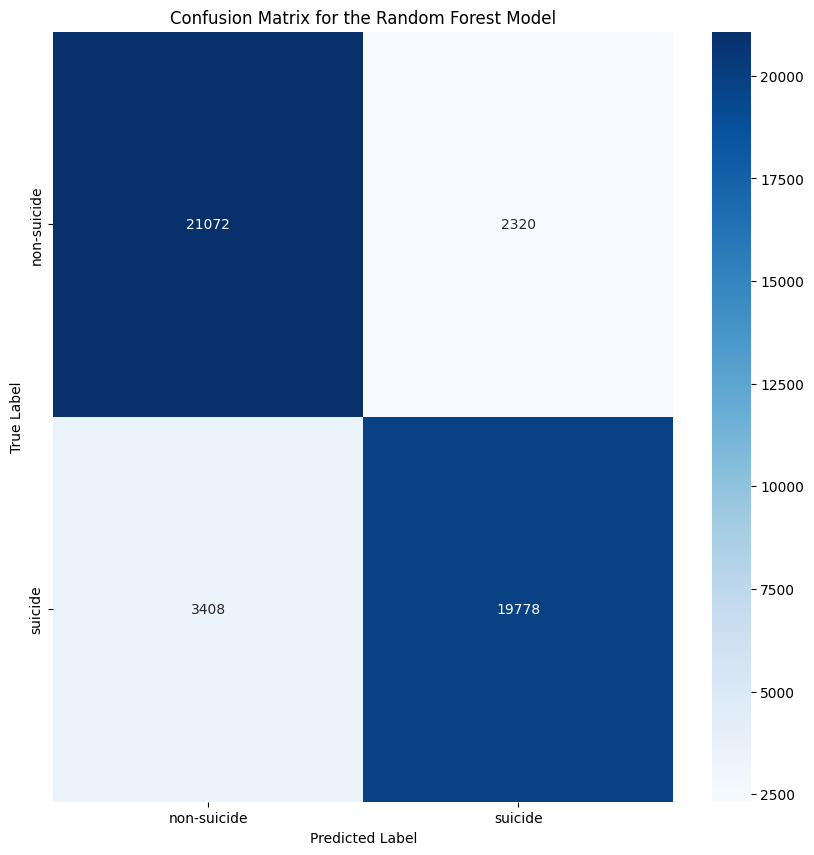

In [79]:
# Create the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create the heatmap using seaborn
plt.subplots(figsize=(10,10))
sns.heatmap(cm_rf, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

# Set the axis labels
plt.title('Confusion Matrix for the Random Forest Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()

### Random Forest Confusion Matrix with Estimators 50

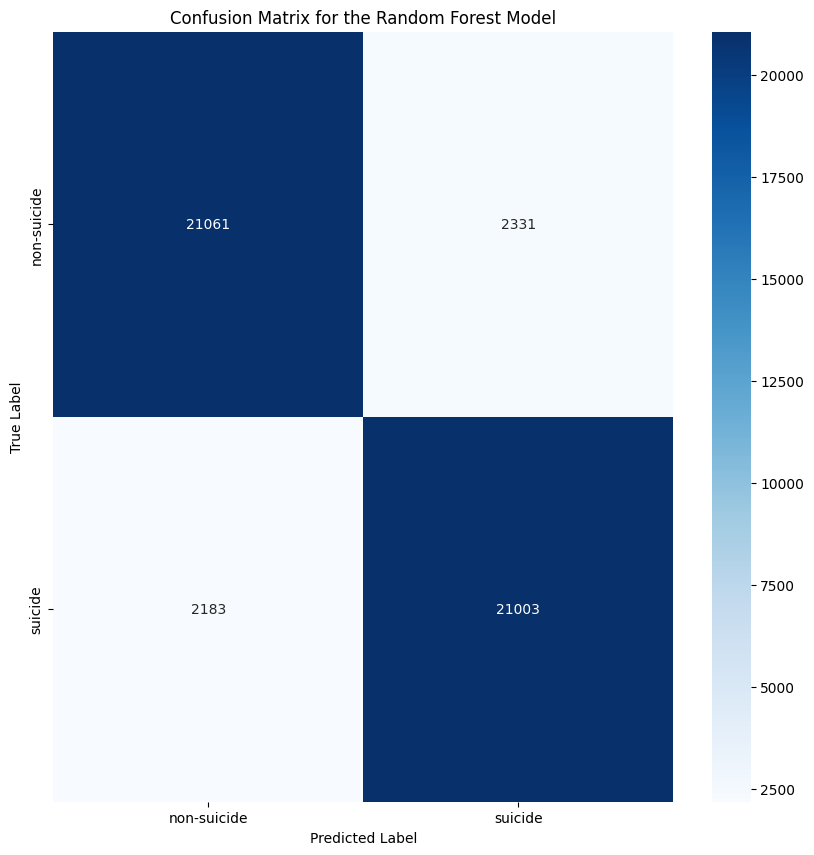

In [80]:
# Create the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf2)

# Create the heatmap using seaborn
plt.subplots(figsize=(10,10))
sns.heatmap(cm_rf, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

# Set the axis labels
plt.title('Confusion Matrix for the Random Forest Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()

# Prediction Function

In [81]:
def predicted_class(text, rf_model, nb_model):
    # Preprocess the text
    preprocessed_text = preprocess_text([text])[0]
    
    # Transform the preprocessed text with the TfidfVectorizer
    tfidf_text = vectorizer.transform([preprocessed_text])
    
    # Get the predicted probabilities for each class from the Random Forest model
    rf_pred_prob = rf_model.predict_proba(tfidf_text)[0]
    
    # Get the predicted probabilities for each class from the Multinomial Naive Bayes model
    nb_pred_prob = nb_model.predict_proba(tfidf_text)
    
    # Calculate the overall predicted probability for each class by taking the mean of the predicted probabilities
    overall_pred_prob = (rf_pred_prob + nb_pred_prob[0])/2
    
    # Get the predicted class with the highest probability
    predicted_class = classes[np.argmax(overall_pred_prob)]

    #  # Calculate accuracy for Random Forest model
    # rf_accuracy = round(rf_model.score(X_test, y_test) * 100, 2)
    
    # # Calculate accuracy for Multinomial Naive Bayes model
    # nb_accuracy = round(nb_model.score(X_test, y_test) * 100, 2)

    # Capitalize the predicted class to look nicer
    if predicted_class == 'suicide':
        predicted_class = 'Suicide'
    elif predicted_class == 'non-suicide':
        predicted_class = 'Non-Suicide'
    
    print(f"Random Forest Probabilities:\n- Suicide: {rf_pred_prob[1]}\n- Non-Suicide: {rf_pred_prob[0]}")
    print(f"\nNaive Bayes Probabilities:\n- Suicide: {nb_pred_prob[0][1]}\n- Non-Suicide: {nb_pred_prob[0][0]}")

    
    return print(f'\nThe predicted class for the string above is {predicted_class}')



In [104]:
predicted_class("I am really happy right now", clf_rf2, clf)

100%|██████████| 1/1 [00:00<00:00, 6797.90it/s]

Random Forest Probabilities:
- Suicide: 0.1
- Non-Suicide: 0.9

Naive Bayes Probabilities:
- Suicide: 0.6828426869049415
- Non-Suicide: 0.31715731309505907

The predicted class for the string above is Non-Suicide


In [100]:
predicted_class("I want to hurt myself.", clf_rf, clf)

100%|██████████| 1/1 [00:00<00:00, 3880.02it/s]

Random Forest Probabilities:
- Suicide: 0.8
- Non-Suicide: 0.2

Naive Bayes Probabilities:
- Suicide: 0.8222551417922808
- Non-Suicide: 0.1777448582077195

The predicted class for the string above is Suicide


In [99]:
predicted_class("I went for a walk in the park today and enjoyed the beautiful weather.", clf_rf, clf)

100%|██████████| 1/1 [00:00<00:00, 5675.65it/s]

Random Forest Probabilities:
- Suicide: 0.0
- Non-Suicide: 1.0

Naive Bayes Probabilities:
- Suicide: 0.45574028828824464
- Non-Suicide: 0.5442597117117538

The predicted class for the string above is Non-Suicide


In [94]:
predicted_class("Today I am going for a walk at night alone.", clf_rf2, clf)

100%|██████████| 1/1 [00:00<00:00, 6061.13it/s]

Random Forest Probabilities:
- Suicide: 0.3
- Non-Suicide: 0.7

Naive Bayes Probabilities:
- Suicide: 0.6237290495274881
- Non-Suicide: 0.3762709504725121

The predicted class for the string above is Non-Suicide


In [107]:
predicted_class("This is getting too hard. I can't handle this anymore.", clf_rf2, clf)

100%|██████████| 1/1 [00:00<00:00, 5398.07it/s]

Random Forest Probabilities:
- Suicide: 0.78
- Non-Suicide: 0.22

Naive Bayes Probabilities:
- Suicide: 0.9445937040767407
- Non-Suicide: 0.05540629592325873

The predicted class for the string above is Suicide
